In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

In [106]:
pip install pandas-datareader

     |████████████████████████████████| 109 kB 10.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
np.random.seed(0)
close = np.random.randn(5, 4)

In [19]:
returns = close[1:] - close[:-1]

In [20]:
returns

array([[ 0.10350564, -1.37743509, -0.02864957, -2.39225041],
       [-1.97077684,  1.38787638, -0.80604485,  1.60563072],
       [ 0.86425658, -0.28892349,  0.29981966, -1.12059918],
       [ 0.73304135, -0.32683328, -0.13079553, -1.18777007]])

In [21]:
returns_avg = np.mean(returns, axis=0) 

In [22]:
returns_avg

array([-0.06749332, -0.15132887, -0.16641757, -0.77374723])

In [23]:
returns_std = np.std(returns, axis=0)

In [32]:
returns_stand = (returns - returns_avg)/returns_std

In [35]:
num_days = returns_stand.shape[0]

In [46]:
cor = (returns_stand.T@returns_stand)/num_days

In [47]:
eigenvalues, eigenvectors = np.linalg.eig(cor)

In [67]:
eigenport_w = (eigenvectors.T/returns_std).T

In [73]:
pcs = (returns@eigenport_w)/np.sqrt(eigenvalues)

In [80]:
pcs_w = np.sqrt(eigenvalues)*(eigenvectors.T*returns_std).T

In [85]:
returns_reconstructed = (pcs_w@pcs.T).T

In [127]:
pip install yahoo-finance

     |████████████████████████████████| 74 kB 3.6 MB/s eta 0:00:011
  Created wheel for yahoo-finance: filename=yahoo_finance-1.4.0-py3-none-any.whl size=7232 sha256=7fcfa699f5c32057e4bae8213d81d612375774c5e945c08b6bb83dc3df7203c2
  Stored in directory: /Users/kexin/Library/Caches/pip/wheels/74/3c/6e/504622cec9991612b9e3945fe8b375fef727854b42eb333c91
Successfully built yahoo-finance
Note: you may need to restart the kernel to use updated packages.


In [137]:
import pandas as pd
from pandas_datareader import data
import yfinance as yf

In [151]:
# input
symbols = ['AAPL','MSFT','AMD','NVDA','GE']
start = '2012-01-01'
end = '2019-09-11'

# Read data 
dataset = yf.download(symbols,start,end)['Close']

# View Columns
close = dataset.fillna(0)
close = close.to_numpy()

[*********************100%***********************]  5 of 5 completed


In [150]:
close.isna()

,AAPL,AMD,GE,MSFT,NVDA
Date,,,,,
2012-01-03,False,False,False,False,False
2012-01-04,False,False,False,False,False
2012-01-05,False,False,False,False,False
2012-01-06,False,False,False,False,False
2012-01-09,False,False,False,False,False
...,...,...,...,...,...
2019-09-04,False,False,False,False,False
2019-09-05,False,False,False,False,False
2019-09-06,False,False,False,False,False


In [369]:
def myPCA(close):
    #obtain returns
    returns = close[1:] - close[:-1]
    
    #standardize returns
    returns_avg = np.mean(returns, axis=0) 
    returns_std = np.std(returns, axis=0)
    returns_stand = (returns - returns_avg)/returns_std
    
    #formulate correlation
    num_days = returns_stand.shape[0]
    cor = (returns_stand.T@returns_stand)/num_days
    
    #eigendecomposition and sorting of eigenvalues & eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cor)
    eigenvalues_index = np.argsort(eigenvalues)[::-1]
    eigenvalues_sort = eigenvalues[eigenvalues_index]
    eigenvectors_sort = eigenvectors[eigenvalues_index]
    
    #idx = NP.argsort(evals)[::-1]
    #evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    #evals = evals[idx]
    
    #obtain weights of the eigen portfolios
    eigenport_w = (eigenvectors_sort.T/returns_std).T
    
    #eigenport return
    pcs = (returns@eigenport_w)/np.sqrt(eigenvalues_sort)
    
    #weight of eigenport in reconstructed retursn
    pcs_w = np.sqrt(eigenvalues_sort)*(eigenvectors_sort.T*returns_std).T
    returns_reconstructed = (pcs_w@pcs.T).T
    
    #explained variance ratio
    ratio = eigenvalues_sort/np.sum(eigenvalues_sort)
    
    return returns_reconstructed, pcs_w, pcs, ratio, eigenvalues_sort

In [496]:
def PCA_svd(close, num_factors, num_days):
    #pca using svd
    
    returns = close[1:] - close[:-1]
    
    total_time = returns.shape[0]
    
    #obtain eigenvalues & eigenvectors for given timeframe
    index = 0
    
    while index+num_days <= total_time-1:
        #PCA
        prev_returns = returns[index:index+num_days]
        returns_avg = np.mean(prev_returns, axis=0) 
        returns_std = np.std(prev_returns, axis=0)
        
        index = []
        
        for i in range(len(returns_std)):
            if returns_std[i] == 0:
                index.append(i)
                
        prev_returns_nzero = np.delete(prev_returns, index, axis = 1)
        returns_avg = np.delete(returns_avg, index, axis = 1)
        returns_std = np.delete(returns_std, index, axis = 1)
        returns_stand = (prev_returns - returns_avg)/returns_std
        
        if index == 0:
            returns_reconstructed = prev_returns
        
        index += num_days
    
        U, S, V = np.linalg.svd(returns_stand)

        #obtain sorted eigenvalues and eigenvectors
        eigenvectors = V.T
        eigenvalues_index = np.argsort(eigenvalues)[::-1]
        eigenvalues_sort = eigenvalues[eigenvalues_index]
        eigenvectors_sort = eigenvectors[:,eigenvalues_index]
        
        #weight of eigenportfolio
        eigenport_w = (eigenvectors_sort.T/returns_std).T

        #factors 
        curr_returns = returns[index:index+num_days]
        curr_factors = (curr_returns@eigenport_w)/np.sqrt(eigenvalues_sort)

        #weight of factors i.e. beta
        curr_beta = np.sqrt(eigenvalues_sort)*(eigenvectors_sort.T*returns_std).T
        
        #reconstruct returns based on number of factors chosen
        curr_returns_reconstructed= curr_factors[:, :num_factors]@curr_beta[:,:num_factors].T

        #explained variance by each factor
        curr_ratio = eigenvalues_sort/np.sum(eigenvalues_sort)

        if index-num_days == 0:
            beta = curr_beta
            factors = curr_factors
            eigenvec = eigenvectors_sort
            eigenval = eigenvalues_sort
            ratio = curr_ratio
            np.vstack((returns_reconstructed, curr_returns_reconstructed.copy()))
        else:
            beta = np.vstack((beta, curr_beta.copy()))
            factors = np.vstack((factors, curr_factors.copy()))
            eigenvec = np.vstack((eigenvec, eigenvectors_sort.copy()))
            eigenval = np.vstack((eigenval, eigenvalues_sort.copy()))
            ratio = np.vstack((ratio, curr_ratio.copy()))
            returns_reconstructed = np.vstack((returns_reconstructed, curr_returns_reconstructed.copy()))
            
        for i in index:
            returns_reconstructed = np.insert(returns_reconstructed, )

    return returns_reconstructed, beta, factors, ratio, eigenval, eigenvec

In [23]:
n = np.array([[1,2,3],[2,3,4],[3,4,6]])

In [24]:
n[2]

array([3, 4, 6])

In [18]:
np.insert(n, 1, [[0, 2, 3]], axis =1)

array([[1, 0, 2, 3],
       [2, 2, 3, 4],
       [3, 3, 4, 5]])

In [21]:
np.delete(n, [0,1], axis = 1)

array([[3],
       [4],
       [5]])

In [495]:
returns = close[1:] - close[:-1]
    
total_time = returns.shape[0]

num_days = 10
num_factors = 4

#obtain eigenvalues & eigenvectors for given timeframe
index = 0

while index+num_days <= total_time-1:
    print(index)
    #PCA
    prev_returns = returns[index:index+num_days]
    returns_avg = np.mean(prev_returns, axis=0) 
    returns_std = np.std(prev_returns, axis=0)
    returns_stand = (prev_returns - returns_avg)/returns_std

    if index == 0:
        returns_reconstructed = prev_returns

    index += num_days

    U, S, V = np.linalg.svd(returns_stand)

    #obtain sorted eigenvalues and eigenvectors
    eigenvectors = V.T
    eigenvalues_index = np.argsort(eigenvalues)[::-1]
    eigenvalues_sort = eigenvalues[eigenvalues_index]
    eigenvectors_sort = eigenvectors[:,eigenvalues_index]

    #weight of eigenportfolio
    eigenport_w = (eigenvectors_sort.T/returns_std).T

    #factors 
    curr_returns = returns[index:index+num_days]
    curr_factors = (curr_returns@eigenport_w)/np.sqrt(eigenvalues_sort)

    #weight of factors i.e. beta
    curr_beta = np.sqrt(eigenvalues_sort)*(eigenvectors_sort.T*returns_std).T

    #reconstruct returns based on number of factors chosen
    curr_returns_reconstructed= curr_factors[:, :num_factors]@curr_beta[:,:num_factors].T

    #explained variance by each factor
    curr_ratio = eigenvalues_sort/np.sum(eigenvalues_sort)

    if index-num_days == 0:
        beta = curr_beta
        factors = curr_factors
        eigenvec = eigenvectors_sort
        eigenval = eigenvalues_sort
        ratio = curr_ratio
        np.vstack((returns_reconstructed, curr_returns_reconstructed.copy()))
    else:
        beta = np.vstack((beta, curr_beta.copy()))
        factors = np.vstack((factors, curr_factors.copy()))
        eigenvec = np.vstack((eigenvec, eigenvectors_sort.copy()))
        eigenval = np.vstack((eigenval, eigenvalues_sort.copy()))
        ratio = np.vstack((ratio, curr_ratio.copy()))
        returns_reconstructed = np.vstack((returns_reconstructed, curr_returns_reconstructed.copy()))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920


In [484]:
returns.shape[0]

1933

In [497]:
returns_reconstructed, beta, factors, ratio, eigenvalues_sort, eigenvectors_sort = PCA_svd(close, 4, 10)

In [498]:
returns_reconstructed

array([[ 0.07892799, -0.01999998,  1.53845215,  0.62999916,  0.03999996],
       [ 0.16392899,  0.        , -0.07691956,  0.28000069,  0.12750006],
       [ 0.15607166, -0.03000021,  0.76922607,  0.43000031, -0.04250002],
       ...,
       [-0.57210405, -0.6962589 , -0.66227967, -0.79342352, -0.05497592],
       [ 0.22617308, -0.05942876,  2.00032247, -1.57963523,  0.46301085],
       [ 0.23874133, -0.10076258,  1.53562834, -1.33128833,  0.82103435]])

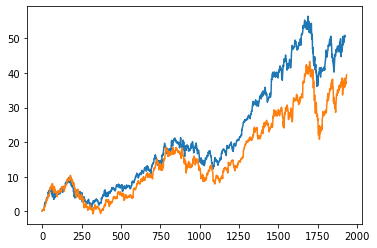

In [503]:
plt.plot(returns_reconstructed[:,0].cumsum())
plt.plot(returns[:,0].cumsum())

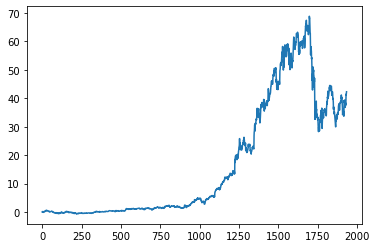

In [466]:
plt.plot(returns[:,4].cumsum())

In [475]:
n = np.array([[1,2,3,4],[1,2,3,4],[1,2,3,4]])

In [476]:
n[0:2]

array([[1, 2, 3, 4],
       [1, 2, 3, 4]])

In [458]:
np.vstack((u,np.array(n)))

array([[1, 2],
       [1, 3],
       [1, 2],
       [1, 3]])

In [396]:
n = np.array([[1,2], [1,3]])

In [397]:
n.mean(axis=0)

array([1. , 2.5])

In [426]:
l = np.array([[1,2], [1,3]])

In [431]:
np.vstack((l,n))[:, 0]

array([1, 1, 1, 1])

In [401]:
l

[[1, 2],
 [1, 3],
 array([[1, 2],
        [1, 3]])]

In [444]:
returns_reconstructed, pcs_w, pcs, ratio, eigenvalues = myPCA(close)

In [377]:
close.shape

(1934, 5)

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter

In [342]:
pca = PCA()
r = close[1:] - close[:-1]
#cov = r.T@r
pca.fit(np.corrcoef(r.T))
pcs_sklearn = pca.components_
eigenvalues_sklearn = pca.explained_variance_
#pcs_w = np.sqrt(eigenvalues)*(eigenvectors.T*returns_std).T
#eigenport = (r@eigenport_w)/np.sqrt(eigenvalues)
eigenport_w = (pcs_sklearn.T/np.std(r, axis=0)).T
#pcs = (returns@eigenport_w)/np.sqrt(eigenvalues)
eigenport = (r@eigenport_w)/np.sqrt(eigenvalues_sklearn)
factor_weights = np.sqrt(eigenvalues_sklearn)*(pcs_sklearn.T*np.std(r, axis=0)).T
returns_reconstructed_sklearn = (factor_weights@eigenport.T).T

In [375]:
np.corrcoef(r.T).mean(axis=0)

array([0.50785024, 0.46267797, 0.34775826, 0.53570337, 0.5119043 ])

In [324]:
correlation = np.corrcoef(r.T)

In [358]:
pcs_sklearn

array([[-0.20097011, -0.40764651,  0.70582659, -0.26845788, -0.47241351],
       [-0.63963058,  0.5878979 ,  0.02599301, -0.48788275,  0.08089231],
       [-0.47290704, -0.46052361,  0.14804384,  0.19088665,  0.71128211],
       [-0.45196389,  0.20568269,  0.03018409,  0.77856713, -0.38255118],
       [ 0.35010185,  0.48354215,  0.69159607,  0.21747711,  0.34353204]])

In [371]:
eigenvectors

array([[-0.48486863, -0.11053612,  0.53935275, -0.49117362, -0.46960756],
       [-0.43374256,  0.34633288, -0.64508425,  0.12866697, -0.50914836],
       [-0.25067549, -0.88276214, -0.38393659, -0.05688445,  0.08514487],
       [-0.51672949, -0.0420611 ,  0.35530168,  0.76238973,  0.15409122],
       [-0.4969127 ,  0.29461358, -0.13899041, -0.39713894,  0.69945903]])

In [373]:
np.square(eigenvalues)

array([5.95376139, 0.89439858, 0.50591422, 0.23077174, 0.17857123])

In [368]:
pca.explained_variance_ratio_

array([5.25460918e-01, 2.73518523e-01, 1.12976390e-01, 8.80441693e-02,
       3.58920824e-33])

In [361]:
ratio

array([0.48800661, 0.1891453 , 0.14225529, 0.09607741, 0.08451538])

In [325]:
[3,2,3,4][::-1]

[4, 3, 2, 3]

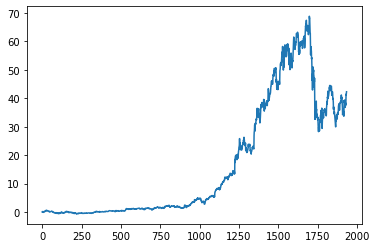

In [383]:
plt.plot(returns_reconstructed_sklearn[:,4].cumsum())

In [425]:
returns_reconstructed

[array([[ 9.39887753e-02, -7.20338888e-02,  1.68092885e+00,
          5.17049725e-01,  4.75295025e-02],
        [ 1.61800604e-01,  7.35340270e-03, -9.70542832e-02,
          2.95962638e-01,  1.26435987e-01],
        [ 1.62295145e-01, -5.15018889e-02,  8.28100920e-01,
          3.83326845e-01, -3.93886293e-02],
        [-2.36442585e-02,  1.59017799e-01,  1.61807727e+00,
         -3.72133596e-01,  1.42175847e-04],
        [ 7.82954246e-02,  3.58134971e-02, -8.46404505e-01,
         -8.27420929e-02, -2.81795555e-03],
        [-1.57502704e-02,  6.92763609e-02,  1.31489963e+00,
         -1.86692100e-01, -6.80541554e-02],
        [-2.41323072e-02, -4.97570912e-02,  5.48237608e-01,
          1.50286124e-01, -1.38526465e-02],
        [-5.69236998e-02, -1.58290859e-01, -6.96987293e-01,
          2.53710718e-01, -9.27475771e-02],
        [ 1.80502407e-01,  4.97581301e-02, -7.13815565e-01,
         -3.39389497e-02, -4.95706566e-02],
        [ 1.67437499e-01,  2.05667356e-01,  2.24786171e+00,
    

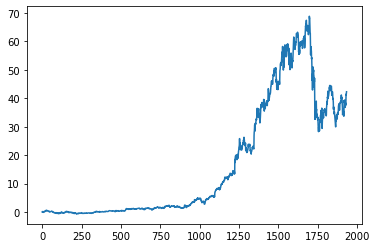

In [353]:
plt.plot(returns[:,4].cumsum())

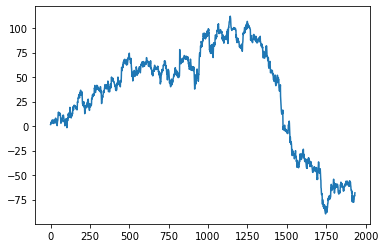

In [315]:
plt.plot(returns_reconstructed_svd[:,2].cumsum())

In [228]:
returns = close[1:] - close[:-1]
returns_avg = np.mean(returns, axis=0) 
returns_std = np.std(returns, axis=0)
returns_stand = (returns - returns_avg)/returns_std
num_days = returns_stand.shape[0]
S,V,D = np.linalg.svd(returns_stand)

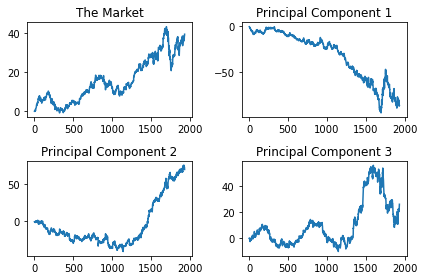

In [356]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(returns[:,0].cumsum())
ax1.set_title('The Market')
plots = [ax2, ax3, ax4]
for i in range(3):
    rc = pcs[:,i]
    plots[i].plot(pcs[: ,i].cumsum())
    plots[i].set_title(f'Principal Component {i+1}')
fig.tight_layout()

In [357]:
pcs_w

array([[-0.39488547, -0.05604492,  0.23715994, -0.17749246, -0.15916119],
       [-0.31433313,  0.15625602, -0.25240382,  0.04137357, -0.15355271],
       [-0.87723222, -1.92323045, -0.72541006, -0.08832712,  0.12399843],
       [-0.76963838,  0.28408238, -0.11622855, -0.27292724,  0.45084153],
       [-0.63001735, -0.03192676,  0.23388797,  0.41244316,  0.07818477]])

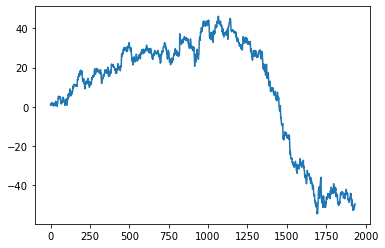

In [274]:
plt.plot(-pcs[: ,1].cumsum())

In [237]:
pcs_w

array([[-0.39488547, -0.05604492,  0.23715994, -0.16647044, -0.16969926],
       [-0.31433313,  0.15625602, -0.25240382,  0.03880433, -0.16371945],
       [-0.87723222, -1.92323045, -0.72541006, -0.08284214,  0.13220838],
       [-0.80033142, -0.04055759,  0.29711546,  0.49140399,  0.10589667],
       [-0.60585593,  0.22362839, -0.0914946 , -0.20150543,  0.37839844]])

In [214]:
ratio

array([0.48800661, 0.1891453 , 0.14225529, 0.08451538, 0.09607741])

In [220]:
pcs_w.sum(axis=1)

array([-0.54994015, -0.53539605, -3.47650649,  0.05352711, -0.29682912])

In [180]:
returns

array([[ 0.07892799, -0.01999998,  1.53845215,  0.62999916,  0.03999996],
       [ 0.16392899,  0.        , -0.07691956,  0.28000069,  0.12750006],
       [ 0.15607166, -0.03000021,  0.76922607,  0.43000031, -0.04250002],
       ...,
       [-0.00500107, -0.94000053, -0.80000305, -0.94999695, -0.2725029 ],
       [ 0.22750092, -0.05999947,  2.        , -1.58000183,  0.46250153],
       [ 0.63249969, -0.27000046,  1.44000244, -1.44000244,  0.66999817]])

In [156]:
returns = close[1:] - close[:-1]
returns_avg = np.mean(returns, axis=0) 
returns_std = np.std(returns, axis=0)
returns_stand = (returns - returns_avg)/returns_std
num_days = returns_stand.shape[0]
cor = (returns_stand.T@returns_stand)/num_days

In [157]:
cor

array([[1.        , 0.31763588, 0.23416385, 0.55903874, 0.42841271],
       [0.31763588, 1.        , 0.12840944, 0.37384144, 0.49350309],
       [0.23416385, 0.12840944, 1.        , 0.24212448, 0.13409355],
       [0.55903874, 0.37384144, 0.24212448, 1.        , 0.50351217],
       [0.42841271, 0.49350309, 0.13409355, 0.50351217, 1.        ]])

In [158]:
eigenvalues, eigenvectors = np.linalg.eig(cor)

In [164]:
eigenport_w = (eigenvectors.T/returns_std).T

In [165]:
eigenport_w

array([[-0.92998271, -0.21200935,  1.03448377, -0.94207575, -0.90071184],
       [-0.93491422,  0.74650626, -1.39045253,  0.27733637, -1.09744832],
       [-0.11189406, -0.39403868, -0.17137784, -0.02539152,  0.03800613],
       [-0.52114009, -0.04242012,  0.3583344 ,  0.76889719,  0.15540648],
       [-0.63663234,  0.37745167, -0.17807109, -0.50880464,  0.89612971]])

In [159]:
pcs = (returns@eigenport_w)/np.sqrt(eigenvalues)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 5)

In [160]:
returns.shape

(1933, 5)

In [161]:
eigenport_w.shape

(4, 4)

In [86]:
returns_reconstructed

array([[ 0.10350564, -1.37743509, -0.02864957, -2.39225041],
       [-1.97077684,  1.38787638, -0.80604485,  1.60563072],
       [ 0.86425658, -0.28892349,  0.29981966, -1.12059918],
       [ 0.73304135, -0.32683328, -0.13079553, -1.18777007]])

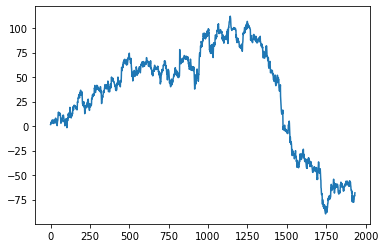

In [213]:
plt.plot(returns_reconstructed[:,2].cumsum())

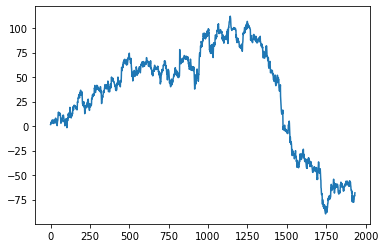

In [212]:
plt.plot(returns[:,2].cumsum())

In [186]:
df = close

In [189]:
close.mean(1).add(1)

AttributeError: 'numpy.ndarray' object has no attribute 'add'

In [57]:
m = np.array([[2,2,3]])

In [59]:
(n.T/m).T

array([[0.5       , 1.        , 1.5       ],
       [0.5       , 1.        , 1.5       ],
       [0.33333333, 0.66666667, 1.        ]])

In [63]:
returns

array([[4, 4, 6],
       [4, 4, 6],
       [6, 6, 9]])

In [70]:
n = np.array([[1,2,3],[1,2,3],[1,2,3]])

In [71]:
s = np.sqrt(m)

In [72]:
n/s

array([[0.70710678, 1.41421356, 1.73205081],
       [0.70710678, 1.41421356, 1.73205081],
       [0.70710678, 1.41421356, 1.73205081]])